# Coronavirus (COVID-19) England Map
## David Beavan @DavidBeavan
## Licence: MIT. Sources: see below
## 👇 Scroll down for maps and tables 👇
## Notes
* This does what other maps do not, it shows cases per population
* England only at the moment (I would like to merge Scotland, Wales and NI)
* UK dataset https://www.gov.uk/government/publications/covid-19-track-coronavirus-cases 'UTLA cases table'
* Maps reported cases and those with location
* The dataset above may not always be up to date
* Population estimates are from ONS, mid-2018
* I am not distributing any data, but it will be fetched
* The government has been actively updating the data made available, this might break this tool

In [1]:
# load libraries
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
import shutil
import io
import zipfile
import datetime
from PIL import Image
from IPython.display import Image as IPyImage
%matplotlib inline

In [2]:
# Prep data
# Data is not packaged with code, Will download from sources and save for
# future runs


def prep_data():
    data_base_dir = Path('data/primary_sources')
    data_base_dir.mkdir(parents=True, exist_ok=True)

    try:
        # https://geoportal.statistics.gov.uk/datasets/counties-and-unitary-authorities-december-2019-boundaries-uk-bgc
        # This file contains the digital vector boundaries for Counties and Unitary Authorities in the United Kingdom, as at December 2019
        # Office for National Statistics licensed under the Open Government Licence v.3.0
        # Contains OS data © Crown copyright and database right 2019

        data_sub_dir = data_base_dir.joinpath('utla_boundaries')

        if not data_sub_dir.is_dir():
            r = requests.get(
                'https://opendata.arcgis.com/datasets/29827d4c079349888acd7db3f84e3449_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D')

            data_sub_dir.mkdir(parents=True)

            myzipfile = zipfile.ZipFile(io.BytesIO(r.content))
            myzipfile.extractall(data_sub_dir)
    except BaseException:
        print('Error: Could not fetch utla_boundaries')

    try:
        # https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland
        # Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland as at mid-2018
        # Office for National Statistics licensed under the Open Government Licence
        # Crown copyright 2019

        data_sub_dir = data_base_dir.joinpath('population_estimates')

        if not data_sub_dir.is_dir():
            r = requests.get('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fpopulationestimatesforukenglandandwalesscotlandandnorthernireland%2fmid20182019laboundaries/ukmidyearestimates20182019ladcodes.xls')

            data_sub_dir.mkdir(parents=True)

            file = open(data_sub_dir.joinpath(
                'ukmidyearestimates20182019ladcodes.xls'), 'wb')
            file.write(r.content)
            file.close()
    except BaseException:
        print('Error: Could not fetch population_estimates')


prep_data()

# Maps

In [3]:
# Load Upper Tier Local Authority (UTLA) AKA Counties and unitary Authorities boundary shapefile
utla_df = gpd.read_file(Path(
    "data/primary_sources/utla_boundaries/Counties_and_Unitary_Authorities_December_2019_Boundaries_UK_BGC.shp"))

# Remove Scotland and NI (for now, this is only parsing England data)
utla_df = utla_df[~utla_df['ctyua19cd'].str.contains('^[SN]')]

# Remove Wales (for now, this is only parsing England data)
utla_df = utla_df[utla_df['ctyua19nmw'].isnull()]

# Drop unused columns
utla_df.drop(columns=['objectid', 'ctyua19nmw', 'bng_e',
                      'bng_n', 'long', 'lat', 'st_lengths'], inplace=True)

# Index on ctyua19cd AKA region code
utla_df.set_index('ctyua19cd', inplace=True)

In [4]:
# Preview data
# utla_df.head()

In [5]:
# Preview map

# ax = utla_df.plot()
# ax.axis('off')

In [6]:
# Preview London map

# ax = utla_df.plot()
# ax.set_xlim([500000, 560000])
# ax.set_ylim([150000, 210000])
# ax.axis('off')

In [7]:
# Load population estimates mid-2018
pop_df = pd.read_excel(Path("data/primary_sources/population_estimates/ukmidyearestimates20182019ladcodes.xls"),
                       header=4, sheet_name='MYE3', usecols='A:O')

# Drop unused columns
pop_df.drop(columns=['Name', 'Geography1', 'Estimated Population  mid-2017', 'Births', 'Deaths', 'Births minus Deaths', 'Internal Migration Inflow', 'Internal Migration Outflow',
                     'Internal Migration Net', 'International Migration Inflow', 'International Migration Outflow', 'International Migration Net', 'Other'], inplace=True)

# Rename population column
pop_df.rename(
    columns={'Estimated Population  mid-2018': 'population'}, inplace=True)

# Index on Code AKA region code
pop_df.set_index('Code', inplace=True)

In [8]:
# Preview data
# pop_df.head()

In [9]:
# Check all regions in utla have population estimates

if len(list(set(utla_df.index).difference(pop_df.index))) != 0:
    print('Error: Not all regions have population data')
    
# if len(list(set(pop_df.index).difference(utla_df.index))) != 0:
#     print('Error: Not all population data have regions')

# There will be regions from the population estimates that do not have an entry in utla.
# The population data has larger areas than utlas, e.g. nations, it also has Scotland, NI and Wales

In [10]:
# Join the population estimates to the utla regions
utla_pop_df = utla_df.join(pop_df)

In [11]:
# The England covid-19 data merges Hackney and City of London, and Cornwall and Isles of Scilly, we must do the same


def merge_areas(df, area1, area2, new_index, new_title):
    # Get first area info, and delete it
    area1_rows = df.loc[df['ctyua19nm'] == area1]
    if len(area1_rows) != 1:
        print('Error: Cannot find entry')
    area1_row = area1_rows.iloc[0]
    df = df[df['ctyua19nm'] != area1]

    # Get second area info, and delete it
    area2_rows = df.loc[df['ctyua19nm'] == area2]
    if len(area2_rows) != 1:
        print('Error: Cannot find entry')
    area2_row = area2_rows.iloc[0]
    df = df[df['ctyua19nm'] != area2]

    # Merge areas and insert new combigned area
    new_shape = area1_row['geometry'].union(area2_row['geometry'])
    new_row = [new_title, area1_row['st_areasha'] + area2_row['st_areasha'],
               new_shape, area1_row['population'] + area2_row['population']]
    df.loc[new_index] = new_row

    return df


# merge areas, give them the index code (e.g. E09000012) used by the Government covid cases dataset
# utla_pop_df = merge_areas(utla_pop_df, 'Hackney', 'City of London',
#                           'E09000012', 'Hackney and City of London')
utla_pop_df = merge_areas(utla_pop_df, 'Cornwall', 'Isles of Scilly',
                          'E06000052', 'Cornwall and Isles of Scilly')

In [12]:
# Preview data
# utla_pop_df.head()

In [13]:
def show_map(df, variable, title, size, cmap, limits=None, save_filename=None):

    # Prep plot
    fig, ax = plt.subplots(1, figsize=size, facecolor='LightGray')

    # Zoom in to limits, if given
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])

    # Plot map
    df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='gray')

    # Remove the axis
    ax.axis('off')

    # Add title
    ax.set_title(title, fontdict={
                 'fontsize': 'xx-large', 'fontweight': 'bold'})

    # Add attributions
    ax.annotate('Code: David Beavan Twitter:@DavidBeavan GitHub:https://github.com/DavidBeavan/coronavirus_covid-19\nPopulation estimates mid-2018\nSource: Office for National Statistics licensed under the Open Government Licence\nContains OS data © Crown copyright and database right 2019',
                xy=(0.02, .08), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize='medium', color='black')

    # Add legend
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=0, vmax=variable.max()))
    sm._A = []
    cbar = fig.colorbar(sm)

    # Save map
    if save_filename is not None:
        fig.savefig(save_filename, dpi=100, facecolor='LightGray')

In [14]:
# Population map
# show_map(utla_pop_df, utla_pop_df['population'] / 1000,
#          'Population (raw) (1,000s)', (12, 12), 'Greys')

In [15]:
# Population map London
# show_map(utla_pop_df, utla_pop_df['population'] / 1000, 'Population (raw) London (1,000s)',
#          (12, 12), 'Greys', ([500000, 560000], [150000, 210000]))

In [16]:
# Population density map
# show_map(utla_pop_df, (utla_pop_df['population'] / 1000) / (utla_pop_df['st_areasha'] /
#                                                             1000000), 'Population (density) (1,000s per km2)', (12, 12), 'Greens')

In [17]:
# Population density map London
# show_map(utla_pop_df, (utla_pop_df['population'] / 1000) / (utla_pop_df['st_areasha'] / 1000000),
#          'Population (density) London (1,000s per km2)', (12, 12), 'Greens', ([500000, 560000], [150000, 210000]))

In [18]:
# Load time series case dataset
# As fetched and saved by the scraper
# coronavirus_covid-19_england_cases_scraper.ipynb
utla_cases_time_series_df = pd.read_csv(Path(
    'data/secondary_sources/utla_cases_table/utla_cases.csv'), index_col='utla')

# Drop unneeded columns
utla_cases_time_series_df.drop(columns=['GSS_NM'], inplace=True)

# Set maps output directoru
maps_output_dir = Path('outputs/maps')

In [19]:
# Check all regions in utla have covid case data

if len(list(set(utla_pop_df.index).difference(utla_cases_time_series_df.index))) != 0:
    print('Error: Not all regions have covid case data')
    
if len(list(set(utla_cases_time_series_df.index).difference(utla_pop_df.index))) != 0:
    print('Error: Not all covid case data have regions')

In [20]:
# Join the time series case dataset to utla population
utla_pop_time_series_df = utla_pop_df.join(utla_cases_time_series_df)

In [21]:
# To normalise the counts, we need to know the maximum value for any area across all time

date_cols = utla_pop_time_series_df.iloc[:, 4:]
# date_cols

case_count_max = date_cols.values.max()
# print(case_count_max)

max_date = date_cols.columns[-1]
# max_date

# Add new columns to summerise total cases per 1,000 ppl
for date in date_cols:
    utla_pop_time_series_df[date + '_per_1000'] = (
        utla_pop_time_series_df[date] / (utla_pop_time_series_df['population'] / 1000))

date_cols_normalised = utla_pop_time_series_df.iloc[:, 4 + len(date_cols.columns):]
# date_cols_normalised

max_date_normalised = date_cols_normalised.columns[-1]
# max_date_normalised

case_count_max_normalised = date_cols_normalised.values.max()
# print(case_count_max_normalised)

In [22]:
# Preview data
# utla_pop_time_series_df.head()

In [23]:
# Set maps output directory
maps_output_dir = Path('outputs/maps')
maps_output_dir.mkdir(parents=True, exist_ok=True)

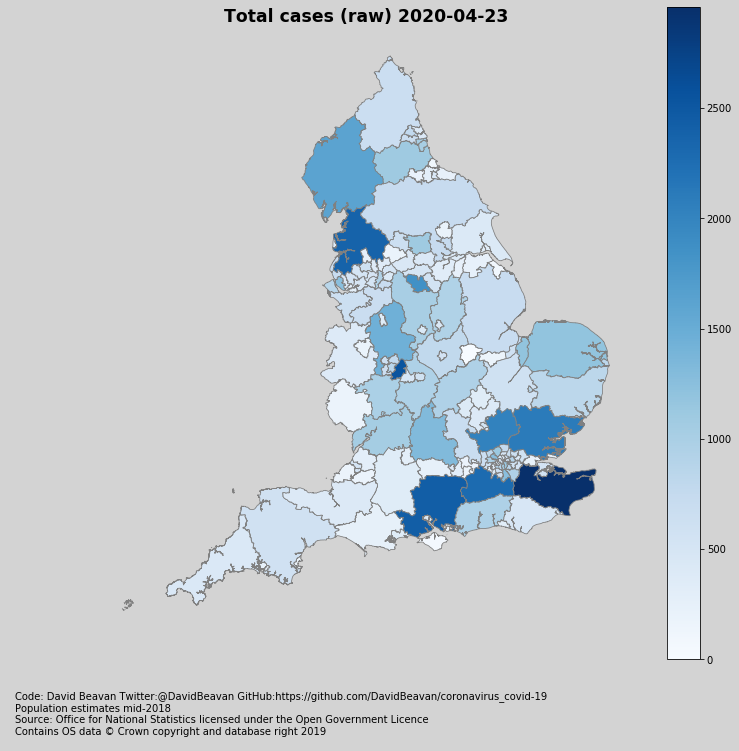

In [24]:
# Cases map
show_map(utla_pop_time_series_df, utla_pop_time_series_df[max_date],
         'Total cases (raw) ' + max_date, (12, 12), 'Blues', save_filename=maps_output_dir.joinpath('coronavirus_covid-19_england_map_raw_' + max_date + '.png'))

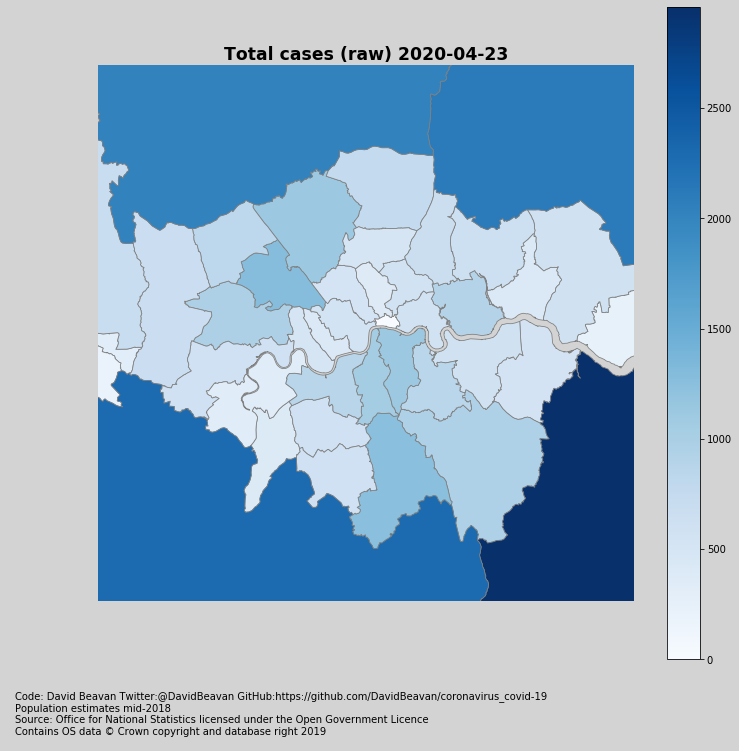

In [25]:
# Cases map London
show_map(utla_pop_time_series_df, utla_pop_time_series_df[max_date],
         'Total cases (raw) ' + max_date, (12, 12), 'Blues', ([500000, 560000], [150000, 210000]), save_filename=maps_output_dir.joinpath('coronavirus_covid-19_london_map_raw_' + max_date + '.png'))

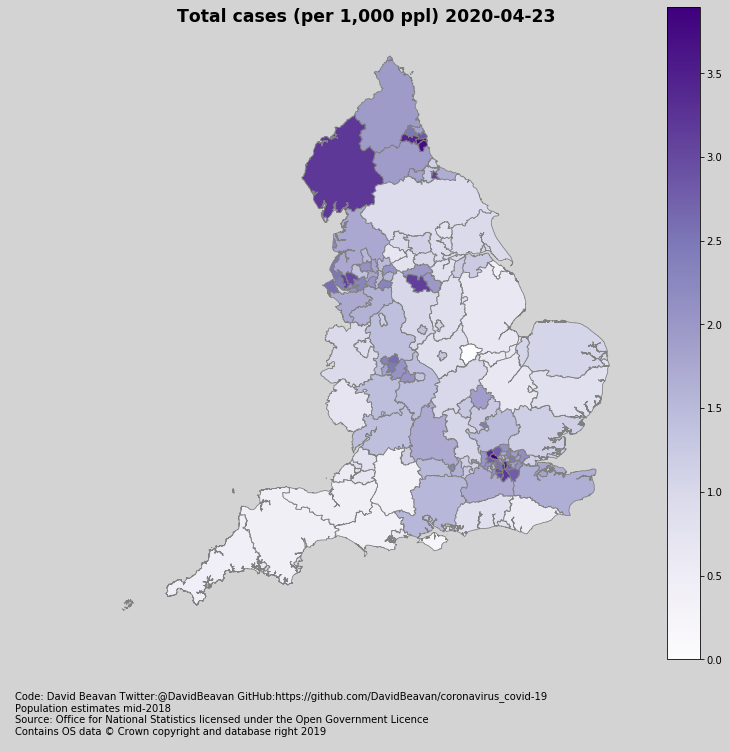

In [26]:
# Cases map per 1,000 ppl
show_map(utla_pop_time_series_df, utla_pop_time_series_df[max_date_normalised],
         'Total cases (per 1,000 ppl) ' + max_date, (12, 12), 'Purples', save_filename=maps_output_dir.joinpath('coronavirus_covid-19_england_map_normalised_' + max_date + '.png'))

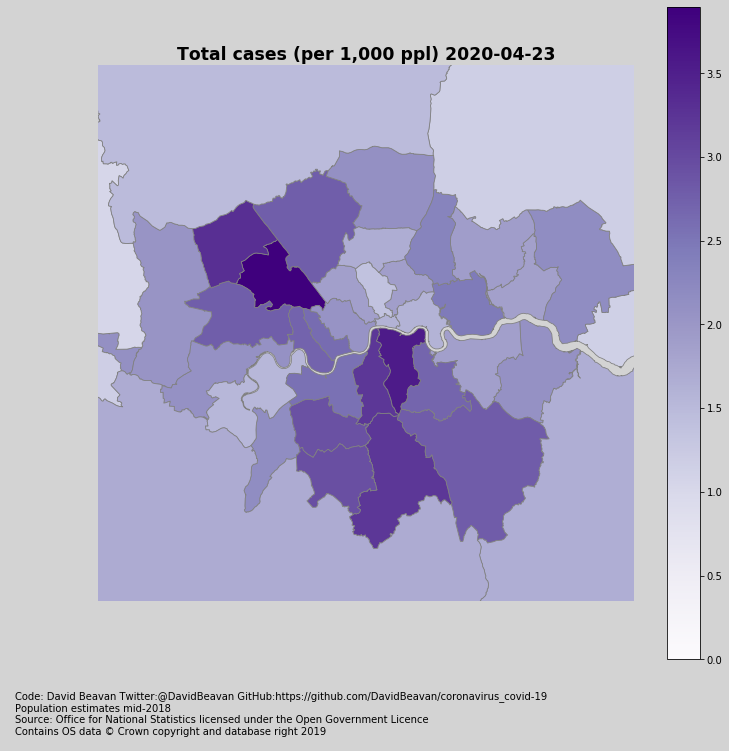

In [27]:
# Cases map per 1,000 ppl London
show_map(utla_pop_time_series_df, utla_pop_time_series_df[max_date_normalised],
         'Total cases (per 1,000 ppl) ' + max_date, (12, 12), 'Purples', ([500000, 560000], [150000, 210000]), save_filename=maps_output_dir.joinpath('coronavirus_covid-19_london_map_normalised_' + max_date + '.png'))

# Tables

In [28]:
# Number of cases (where location is known)
utla_pop_time_series_df[max_date].sum()

100680

In [29]:
# Top cases (raw)
utla_pop_time_series_df.sort_values([max_date, 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', max_date]].head(10)

,ctyua19nm,population,2020-04-23
E10000016,Kent,1568623.0,2959
E08000025,Birmingham,1141374.0,2552
E10000014,Hampshire,1376316.0,2439
E10000017,Lancashire,1210053.0,2381
E10000030,Surrey,1189934.0,2288
E10000012,Essex,1477764.0,2119
E10000015,Hertfordshire,1184365.0,2034
E08000019,Sheffield,582506.0,1856
E10000006,Cumbria,498888.0,1633
E10000028,Staffordshire,875219.0,1455


In [30]:
# Bottom cases (raw)
utla_pop_time_series_df.sort_values([max_date, 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', max_date]].tail(10)

,ctyua19nm,population,2020-04-23
E06000022,Bath and North East Somerset,192106.0,192
E06000024,North Somerset,213919.0,190
E06000031,Peterborough,201041.0,185
E06000036,Bracknell Forest,121676.0,183
E06000027,Torbay,135780.0,177
E06000001,Hartlepool,93242.0,131
E06000012,North East Lincolnshire,159821.0,114
E06000046,Isle of Wight,141538.0,82
E09000001,City of London,8706.0,16
E06000017,Rutland,39697.0,15


In [31]:
# Top cases (per 1,000 ppl)
utla_pop_time_series_df.sort_values([max_date_normalised, 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', max_date_normalised]].head(10)

,ctyua19nm,population,2020-04-23_per_1000
E09000005,Brent,330795.0,3.896673
E08000024,Sunderland,277417.0,3.738055
E09000028,Southwark,317256.0,3.583857
E08000037,Gateshead,202508.0,3.446777
E09000015,Harrow,250149.0,3.361996
E09000008,Croydon,385346.0,3.290549
E09000022,Lambeth,325917.0,3.286113
E10000006,Cumbria,498888.0,3.273280
E06000002,Middlesbrough,140545.0,3.208937
E08000019,Sheffield,582506.0,3.186233


In [32]:
# Bottom cases (per 1,000 ppl)
utla_pop_time_series_df.sort_values([max_date_normalised, 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', max_date_normalised]].tail(10)

,ctyua19nm,population,2020-04-23_per_1000
E06000024,North Somerset,213919.0,0.888187
E10000011,East Sussex,554590.0,0.885339
E06000052,Cornwall and Isles of Scilly,568210.0,0.781401
E10000008,Devon,795286.0,0.759475
E10000027,Somerset,559399.0,0.757956
E06000054,Wiltshire,498064.0,0.740869
E06000059,Dorset,376484.0,0.722474
E06000012,North East Lincolnshire,159821.0,0.713298
E06000046,Isle of Wight,141538.0,0.579350
E06000017,Rutland,39697.0,0.377862


# Animated maps

In [33]:
date_cols = date_cols.iloc[:, -28:]
date_cols_normalised = date_cols_normalised.iloc[:, -28:]

In [34]:
def show_map_for_animation(df, variable, title, date, size, cmap, vmax, limits=None):
    i = 0    
    
    # Prep plot
    fig, ax = plt.subplots(1, figsize=size, facecolor='LightGray')

    # Zoom in to limits, if given
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])

    # Plot map
    df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax,
            edgecolor='gray', norm=plt.Normalize(vmin=0, vmax=vmax))

    # Remove the axis
    ax.axis('off')
    
    # Add title
    ax.set_title(title + ' ' + date, fontdict={
                 'fontsize': 'xx-large', 'fontweight': 'bold'})

    # Add attributions
    ax.annotate('Code: David Beavan Twitter:@DavidBeavan GitHub:https://github.com/DavidBeavan/coronavirus_covid-19\nPopulation estimates mid-2018\nSource: Office for National Statistics licensed under the Open Government Licence\nContains OS data © Crown copyright and database right 2019',
                xy=(0.02, .08), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize='medium', color='black')

    # Add legend
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)

    # Return map without displaying
    buffer = io.BytesIO()
    fig.savefig(buffer, facecolor='LightGray')

    plt.close('all')

    return buffer

In [35]:
def animated_map(df, date_cols, title, size, cmap, vmax, save_as, limits=None, col_names=None):
    i = 0
    images = []

    for date in date_cols:
        if col_names is not None:
            date_txt = col_names[i]
            i += 1
        else:
            date_txt = date
            
        buffer = show_map_for_animation(
            df, df[date], title, date_txt, size, cmap, vmax, limits)

        frame = Image.open(buffer)
        images.append(frame)

    # Save the frames as an animated GIF
    images[0].save(save_as, save_all=True, append_images=images[1:], duration=500,
                   loop=0, palette=Image.ADAPTIVE, include_color_table=True, interlace=False)

In [36]:
output = maps_output_dir.joinpath('coronavirus_covid-19_england_map_raw_animation_' + max_date + '.gif')
animated_map(utla_pop_time_series_df, date_cols,
             'Total cases (raw)', (12, 12), 'Blues', case_count_max, output)
# with open(output,'rb') as f:
#     display(IPyImage(data=f.read(), format='gif'))

In [37]:
output = maps_output_dir.joinpath('coronavirus_covid-19_london_map_raw_animation_' + max_date + '.gif')
animated_map(utla_pop_time_series_df, date_cols,
             'Total cases (raw)', (12, 12), 'Blues', case_count_max, output, ([500000, 560000], [150000, 210000]))
# with open(output,'rb') as f:
#     display(IPyImage(data=f.read(), format='gif'))

In [38]:
output = maps_output_dir.joinpath('coronavirus_covid-19_england_map_normalised_animation_' + max_date + '.gif')
animated_map(utla_pop_time_series_df, date_cols_normalised,
             'Total cases (per 1,000 ppl)', (12, 12), 'Purples', case_count_max_normalised, output, col_names=date_cols.columns)
# with open(output,'rb') as f:
#     display(IPyImage(data=f.read(), format='gif'))

In [39]:
output = maps_output_dir.joinpath('coronavirus_covid-19_london_map_normalised_animation_' + max_date + '.gif')
animated_map(utla_pop_time_series_df, date_cols_normalised,
             'Total cases (per 1,000 ppl)', (12, 12), 'Purples', case_count_max_normalised, output, ([500000, 560000], [150000, 210000]), col_names=date_cols.columns)
# with open(output,'rb') as f:
#     display(IPyImage(data=f.read(), format='gif'))

In [40]:
# Delete old backup
backup_dir = Path('data/primary_sources_bak/primary_sources_bak_' +
                  datetime.date.today().isoformat())
if backup_dir.exists():
    shutil.rmtree(backup_dir)

# Make new backup
shutil.copytree(Path('data/primary_sources'), backup_dir)

PosixPath('data/primary_sources_bak/primary_sources_bak_2020-04-24')